## Simple LP Simulation
* [Medium Article: How to Simulate a Liquidity Pool for Decentralized Finance](https://medium.com/@icmoore/simulating-a-liquidity-pool-for-decentralized-finance-6f357ec8564b)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3
import datetime

In [2]:
from uniswappy.math.model import BrownianModel
from uniswappy.erc import ERC20
from uniswappy.cpt.factory import UniswapFactory
from uniswappy.process.deposit import SwapDeposit
from uniswappy.process.swap import Swap
from uniswappy.simulate import SolveDeltas
from uniswappy.simulate import SimpleLPSimulation

In [3]:
n_steps = 5000
start_price = 0.1
mu = 0.3; sigma = 0.5
n_paths = 25

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

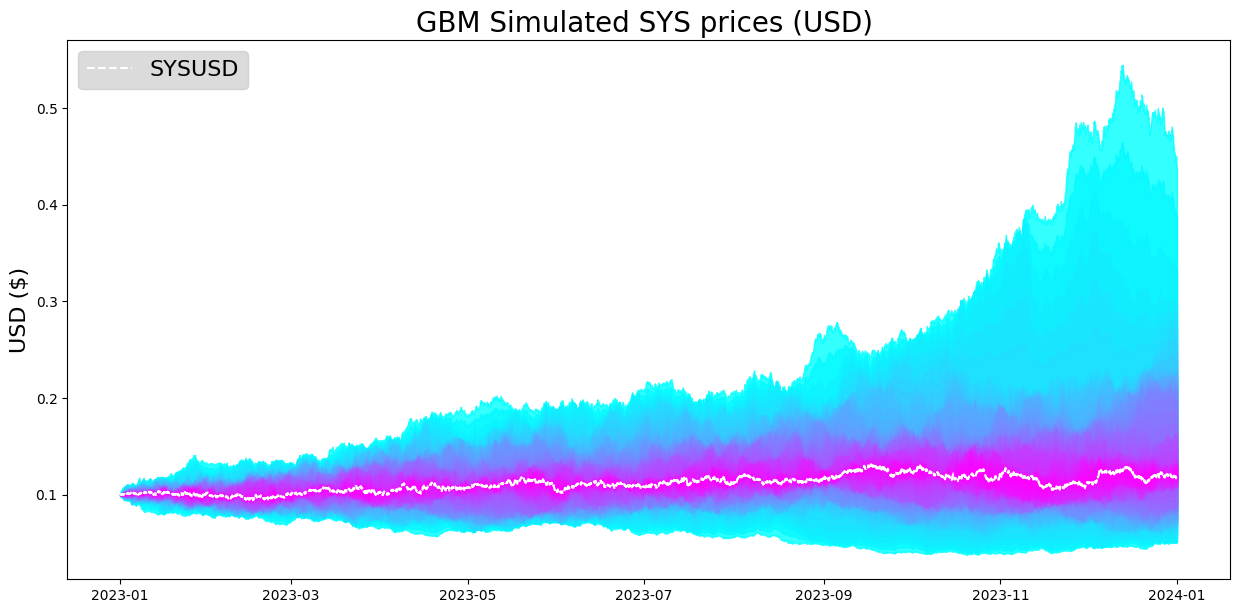

In [4]:
t_deltas = np.linspace(0, 365, num=n_steps+1)
start = datetime.datetime(2023, 1, 1, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(days=t_delta) for t_delta in t_deltas])  

fig = plt.figure(figsize=(15, 7))
USD_ax = fig.gca()

pymc3.gp.util.plot_gp_dist( 
    ax=USD_ax,
    x=date_times,
    samples=p_arr.transpose(),
    palette='cool',
    plot_samples=False
)

USD_ax.plot(date_times, exp_p_arr, color = 'white',linestyle = 'dashed', label='SYSUSD') 
USD_ax.set_title("GBM Simulated SYS prices (USD) ", fontsize=20)
USD_ax.set_ylabel("USD ($)", fontsize=16)
USD_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')

In [5]:
sys_arr = np.zeros((n_steps, n_paths), np.float64)
x_amt_arr = np.zeros((n_steps, n_paths), np.float64)
y_amt_arr = np.zeros((n_steps, n_paths), np.float64)

for k in range(n_paths):
    print(f'Trial run {k}')
    p_trial_arr = p_arr[:,k]
    
    tkn = ERC20('TKN', "0x09")
    dai = ERC20('DAI', "0x111")
    
    lp_sim = SimpleLPSimulation()
    lp_sim.init_amts(10000, p_trial_arr[0])
    lp_sim.create_lp(tkn, dai)
    lp_sim.run(p_trial_arr)
    
    sys_arr[:,k] = lp_sim.get_tkn_price_sim()
    x_amt_arr[:,k] = lp_sim.get_x_amt_sim()
    y_amt_arr[:,k] = lp_sim.get_y_amt_sim()

Trial run 0
Trial run 1
Trial run 2
Trial run 3
Trial run 4
Trial run 5
Trial run 6
Trial run 7
Trial run 8
Trial run 9
Trial run 10
Trial run 11
Trial run 12
Trial run 13
Trial run 14
Trial run 15
Trial run 16
Trial run 17
Trial run 18
Trial run 19
Trial run 20
Trial run 21
Trial run 22
Trial run 23
Trial run 24


Text(0, 0.5, 'DAI')

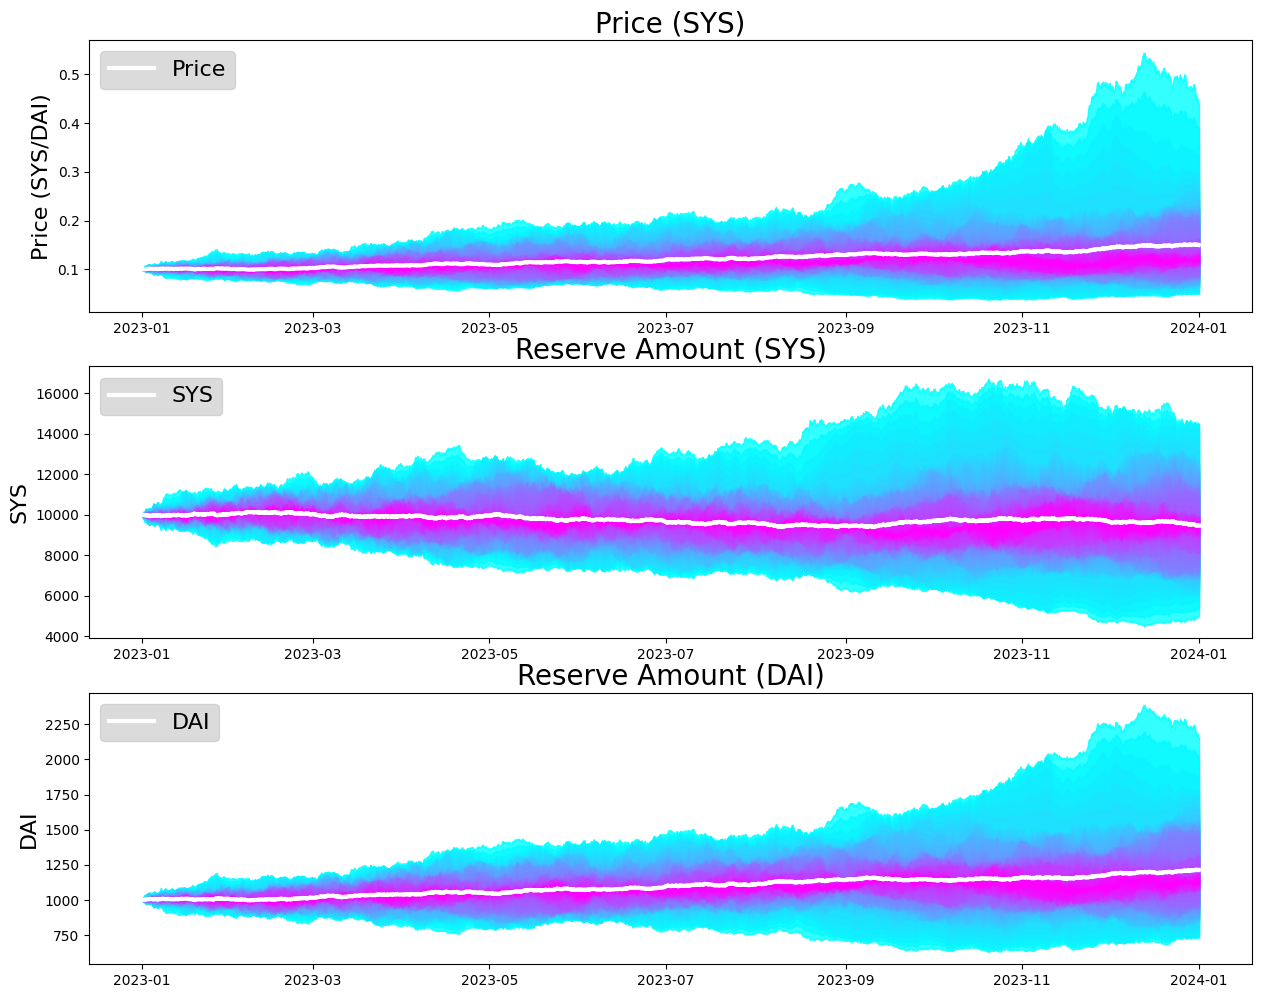

In [6]:
fig, (P_ax, SYS_ax, DAI_ax) = plt.subplots(nrows=3, sharex=False, sharey=False, figsize=(15, 12))

pymc3.gp.util.plot_gp_dist( 
    ax=P_ax,
    x=date_times[1:],
    samples=sys_arr.transpose(),
    palette='cool',
    plot_samples=False
)
P_ax.plot(date_times[1:], np.mean(sys_arr, axis = 1), color = 'w', linewidth=3, label='Price')
P_ax.set_title("Price (SYS)", fontsize=20)
P_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')
P_ax.set_ylabel("Price (SYS/DAI)", fontsize=16)

pymc3.gp.util.plot_gp_dist( 
    ax=SYS_ax,
    x=date_times[1:],
    samples=x_amt_arr.transpose(),
    palette='cool',
    plot_samples=False
)
SYS_ax.plot(date_times[1:], np.mean(x_amt_arr, axis = 1), color = 'w', linewidth=3, label='SYS')
SYS_ax.set_title("Reserve Amount (SYS)", fontsize=20)
SYS_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')
SYS_ax.set_ylabel("SYS", fontsize=16)

pymc3.gp.util.plot_gp_dist( 
    ax=DAI_ax,
    x=date_times[1:],
    samples=y_amt_arr.transpose(),
    palette='cool',
    plot_samples=False
)
DAI_ax.plot(date_times[1:], np.mean(y_amt_arr, axis = 1), color = 'w', linewidth=3, label='DAI')
DAI_ax.set_title("Reserve Amount (DAI)", fontsize=20)
DAI_ax.legend(fontsize=16, facecolor="lightgray", loc='upper left')
DAI_ax.set_ylabel("DAI", fontsize=16)